In [1]:
import pandas as pd
import numpy as np
import math
import keras
import tensorflow as tf
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [2]:
# TO DO__
# pobawić się parametrami
# sposobem budwoania, liczba warst liczba neuronow itp
# pobawic sie wykresami i stworzyc jakies moze ladne te wykresy w koncu

In [3]:
data = pd.read_csv('Data/Scalanie2_2.csv', parse_dates=['Data'])

data.rename(columns = {'(pył zawieszony PM2.5 [jednostka ug/m3])':'PM2.5'
                    , '(pył zawieszony PM10 [jednostka ug/m3])':'PM10'
                    , '(tlenek azotu [jednostka ug/m3])':'NO'
                    , '(tlenki azotu [jednostka ug/m3])':'NOs'
                    , '(tlenek węgla [jednostka ug/m3])':'CO'
                    , '(benzen [jednostka ug/m3])':'benzen'
                    , '(dwutlenek azotu [jednostka ug/m3])':'NO2'
                    , 'B00202A (2).Wynik':'Kierunek wiatru'
                    , 'Scalanie1.B00300S.Wynik':'Temperatura powietrza'
                    , 'Scalanie1.B00606S.Wynik':'Opady'
                    , 'Scalanie1.B00702A.Wynik':'Predkosc wiatru'
                    , 'Scalanie1.B00703A.Wynik':'MAX Predkosc wiatru'
                    , 'Scalanie1.B00802A.Wynik':'Wilgotnosc powietrza'
                    }, inplace = True)

data.dropna(inplace=True)
#data_df = data
# data_df = data_df.reset_index()
# data_df = data_df.drop('index', axis=1)
# data_df.index = data_df['Data']

data = data.drop(['Scalanie1.Stacja','Scalanie1.Data','Scalanie1.Rodzaj'], axis=1)
data['Data'] = pd.to_datetime(data['Data'])
data = data.sort_values(by="Data")

data.set_axis(data['Data'], inplace=True)
data.drop(columns=[ 'PM10', 'CO', 'NO2','benzen', 'NO', 'NOs'], inplace=True)
data = data.drop('Data', axis=1)


In [4]:
data.shape

(22284, 7)

In [5]:
data

,PM2.5,Temperatura powietrza,Opady,Predkosc wiatru,MAX Predkosc wiatru,Wilgotnosc powietrza,Kierunek wiatru
Data,,,,,,,
2019-01-01 01:00:00,34.7,0.566667,0.0,4.016667,4.666667,95.500000,251.666667
2019-01-01 02:00:00,26.0,0.050000,0.0,3.650000,4.333333,96.666667,235.666667
2019-01-01 03:00:00,25.3,-0.500000,0.0,2.850000,3.500000,95.333333,216.166667
2019-01-01 04:00:00,28.2,-0.566667,0.0,3.633333,4.333333,94.833333,207.333333
2019-01-01 05:00:00,32.0,-0.933333,0.0,3.716667,4.166667,93.833333,202.833333
...,...,...,...,...,...,...,...
2021-12-31 19:00:00,18.6,6.700000,0.0,4.216667,6.100000,86.833333,219.833333
2021-12-31 20:00:00,16.6,7.050000,0.0,4.183333,5.766667,86.000000,220.333333
2021-12-31 21:00:00,18.5,6.766667,0.0,4.350000,6.216667,87.500000,213.833333


In [6]:
split_percent = 0.80
split = int(split_percent*len(data['PM2.5']))

df_train = data[:split]
df_test = data[split:]


In [7]:
df_train

,PM2.5,Temperatura powietrza,Opady,Predkosc wiatru,MAX Predkosc wiatru,Wilgotnosc powietrza,Kierunek wiatru
Data,,,,,,,
2019-01-01 01:00:00,34.7,0.566667,0.0,4.016667,4.666667,95.500000,251.666667
2019-01-01 02:00:00,26.0,0.050000,0.0,3.650000,4.333333,96.666667,235.666667
2019-01-01 03:00:00,25.3,-0.500000,0.0,2.850000,3.500000,95.333333,216.166667
2019-01-01 04:00:00,28.2,-0.566667,0.0,3.633333,4.333333,94.833333,207.333333
2019-01-01 05:00:00,32.0,-0.933333,0.0,3.716667,4.166667,93.833333,202.833333
...,...,...,...,...,...,...,...
2021-06-10 20:00:00,6.8,15.466667,0.0,2.316667,2.966667,70.500000,296.166667
2021-06-10 21:00:00,13.5,14.016667,0.0,2.600000,3.300000,79.166667,258.333333
2021-06-10 22:00:00,14.4,13.000000,0.0,3.200000,3.800000,85.333333,250.666667


In [8]:
list = [i for i in data.columns if i != 'Data']
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train[list])
scaled_test = scaler.transform(df_test[list])
# look_back = 3

# train_generator = TimeseriesGenerator(PM25_train, PM25_train, length=look_back, batch_size=20)
# test_generator = TimeseriesGenerator(PM25_test, PM25_test, length=look_back, batch_size=1)


In [9]:
scaled_train

array([[0.12274496, 0.35280679, 0.        , ..., 0.1921757 , 0.94726562,
        0.70429104],
       [0.09197029, 0.3426893 , 0.        , ..., 0.17844887, 0.9609375 ,
        0.65951493],
       [0.08949416, 0.33191906, 0.        , ..., 0.14413178, 0.9453125 ,
        0.60494403],
       ...,
       [0.05093739, 0.59627937, 0.        , ..., 0.15648593, 0.828125  ,
        0.70149254],
       [0.06473293, 0.57800261, 0.        , ..., 0.12285518, 0.86914062,
        0.66697761],
       [0.06473293, 0.57114883, 0.        , ..., 0.12010981, 0.89257812,
        0.64598881]])

In [10]:
def split_sequence(sequence, look_back, forecast_horizon):
 X = []
 y = []
 for i in range(len(sequence)): 
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)
 return np.array(X), np.array(y)

In [11]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY) 

In [12]:
n_features = len(data.columns)
n_features

7

In [13]:
scaled_test

array([[0.06508666, 0.56984334, 0.        , ..., 0.15030885, 0.89257812,
        0.67350746],
       [0.06048815, 0.55842037, 0.        , ..., 0.11530542, 0.90820313,
        0.64225746],
       [0.06296427, 0.5881201 , 0.        , ..., 0.1297186 , 0.86328125,
        0.69123134],
       ...,
       [0.0654404 , 0.47421671, 0.        , ..., 0.25600549, 0.85351562,
        0.59841418],
       [0.06154935, 0.46409922, 0.00613497, ..., 0.28551819, 0.890625  ,
        0.57695896],
       [0.05518217, 0.46377285, 0.10429448, ..., 0.3054221 , 0.92773437,
        0.59328358]])

In [14]:
LOOK_BACK = 24
n_features = len(data.columns)
trainX, trainY = createXY(scaled_train,LOOK_BACK)
testX, testY = createXY(scaled_test,LOOK_BACK)
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

trainX Shape--  (17803, 24, 7)
trainY Shape--  (17803,)
testX Shape--  (4433, 24, 7)
testY Shape--  (4433,)


In [15]:
testY[0]

0.0654403961796958

In [16]:
trainX[0]

array([[0.12274496, 0.35280679, 0.        , 0.23217726, 0.1921757 ,
        0.94726562, 0.70429104],
       [0.09197029, 0.3426893 , 0.        , 0.21098266, 0.17844887,
        0.9609375 , 0.65951493],
       [0.08949416, 0.33191906, 0.        , 0.16473988, 0.14413178,
        0.9453125 , 0.60494403],
       [0.09975239, 0.33061358, 0.        , 0.21001927, 0.17844887,
        0.93945312, 0.58022388],
       [0.1131942 , 0.32343342, 0.        , 0.21483622, 0.17158545,
        0.92773437, 0.5676306 ],
       [0.1054121 , 0.32310705, 0.        , 0.21098266, 0.20590254,
        0.91210938, 0.58022388],
       [0.09727626, 0.34432115, 0.        , 0.28998073, 0.28140014,
        0.83203125, 0.58115672],
       [0.09090909, 0.35802872, 0.        , 0.34682081, 0.33630748,
        0.76757812, 0.57742537],
       [0.0732225 , 0.36422977, 0.        , 0.40462428, 0.38435141,
        0.76953125, 0.5755597 ],
       [0.06119561, 0.36912533, 0.        , 0.39210019, 0.38435141,
        0.83203125, 0.5

In [17]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [18]:
def build_model(optimizer):
    #pytnaie tylko czy liczbaw warst jest odpowiednia, czy funkcja aktywacji sie zgadza etc
    grid_model = Sequential()
    grid_model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(LOOK_BACK,n_features)))
    grid_model.add(LSTM(50))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

In [19]:
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [16,32,40], #tutaj mozna sie pobawic batch size
              'epochs' : [8, 10], #tutaj mozna sie pobawic liczba epoch
              'optimizer' : ['adam'] } #tutaj mozna dodac jakis optimizer, ale adam wszedzie raczej wygrywal


grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

C:\Users\CezaryĆwikła\AppData\Local\Temp\ipykernel_11984\1863182732.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [20]:
grid_search = grid_search.fit(trainX,trainY)


Epoch 1/8
557/557 [==============================] - 6s 9ms/step - loss: 0.0021 - val_loss: 8.5652e-04
Epoch 2/8
557/557 [==============================] - 4s 8ms/step - loss: 8.6567e-04 - val_loss: 6.7563e-04
Epoch 3/8
557/557 [==============================] - 4s 7ms/step - loss: 6.5493e-04 - val_loss: 8.6276e-04
Epoch 4/8
557/557 [==============================] - 4s 8ms/step - loss: 5.7283e-04 - val_loss: 4.8745e-04
Epoch 5/8
557/557 [==============================] - 4s 7ms/step - loss: 5.4226e-04 - val_loss: 4.2153e-04
Epoch 6/8
557/557 [==============================] - 4s 7ms/step - loss: 5.2272e-04 - val_loss: 4.3143e-04
Epoch 7/8
557/557 [==============================] - 4s 7ms/step - loss: 5.2967e-04 - val_loss: 4.2227e-04
Epoch 8/8
557/557 [==============================] - 1s 2ms/step - loss: 4.2336e-04
Epoch 1/8
557/557 [==============================] - 6s 8ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 2/8
557/557 [==============================] - 4s 8ms/step - loss:

279/279 [==============================] - 1s 2ms/step - loss: 4.8416e-04
Epoch 1/8
223/223 [==============================] - 4s 11ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 2/8
223/223 [==============================] - 2s 9ms/step - loss: 0.0014 - val_loss: 9.6176e-04
Epoch 3/8
223/223 [==============================] - 2s 9ms/step - loss: 9.1368e-04 - val_loss: 6.9792e-04
Epoch 4/8
223/223 [==============================] - 2s 9ms/step - loss: 7.5293e-04 - val_loss: 6.8113e-04
Epoch 5/8
223/223 [==============================] - 2s 9ms/step - loss: 6.1698e-04 - val_loss: 7.4999e-04
Epoch 6/8
223/223 [==============================] - 2s 9ms/step - loss: 6.0391e-04 - val_loss: 5.1822e-04
Epoch 7/8
223/223 [==============================] - 2s 9ms/step - loss: 5.7100e-04 - val_loss: 5.2850e-04
Epoch 8/8
223/223 [==============================] - 1s 3ms/step - loss: 3.9369e-04
Epoch 1/8
223/223 [==============================] - 4s 10ms/step - loss: 0.0026 - val_loss: 0.0018
Epoc

In [21]:
grid_search.best_params_


{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [22]:
my_model=grid_search.best_estimator_.model


In [24]:
prediction=my_model.predict(testX)
prediction_copies_array = np.repeat(prediction,n_features, axis=-1)


In [25]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.07508904]
 [0.06420338]
 [0.0763564 ]
 ...
 [0.05829901]
 [0.06536335]
 [0.06114616]]

Prediction Shape- (4433, 1)


In [26]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),n_features)))[:,0]


In [27]:
original_copies_array = np.repeat(testY,n_features, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),n_features)))[:,0]

In [28]:
from matplotlib import pyplot as plt


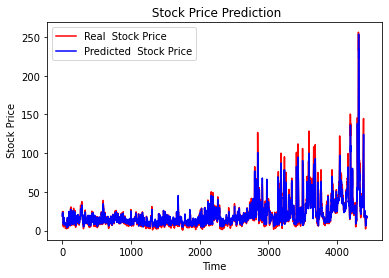

In [29]:
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [30]:
#old -- do wywalenia raczej
# model = Sequential()
# model.add(LSTM(15,  activation='relu', input_shape=(LOOK_BACK, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# num_epochs = 25
# model.fit(epochs=num_epochs, verbose=1)


In [31]:
# prediction = model.predict(test_generator)

# PM25_train = PM25_train.reshape((-1))
# PM25_test = PM25_test.reshape((-1))
# prediction = prediction.reshape((-1))


In [32]:
prediction.shape

(4433, 1)

In [33]:
testY.shape

(4433,)

In [34]:
testScore = math.sqrt(mean_squared_error(original, pred))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 6.03 RMSE


In [46]:
pred

array([21.227673, 18.150295, 21.585953, ..., 16.48113 , 18.478218,
       17.28602 ], dtype=float32)

In [45]:
original

array([18.5, 21.4, 24.3, ..., 18.5, 17.4, 15.6])

In [57]:
len(testX)

4433

In [58]:
testXX=scaler.inverse_transform(np.reshape(testX,(len(testX),n_features)))[:,0]

ValueError: cannot reshape array of size 744744 into shape (4433,7)

In [54]:
testX.shape

(4433, 24, 7)

In [37]:
data

,PM2.5,Temperatura powietrza,Opady,Predkosc wiatru,MAX Predkosc wiatru,Wilgotnosc powietrza,Kierunek wiatru
Data,,,,,,,
2019-01-01 01:00:00,34.7,0.566667,0.0,4.016667,4.666667,95.500000,251.666667
2019-01-01 02:00:00,26.0,0.050000,0.0,3.650000,4.333333,96.666667,235.666667
2019-01-01 03:00:00,25.3,-0.500000,0.0,2.850000,3.500000,95.333333,216.166667
2019-01-01 04:00:00,28.2,-0.566667,0.0,3.633333,4.333333,94.833333,207.333333
2019-01-01 05:00:00,32.0,-0.933333,0.0,3.716667,4.166667,93.833333,202.833333
...,...,...,...,...,...,...,...
2021-12-31 19:00:00,18.6,6.700000,0.0,4.216667,6.100000,86.833333,219.833333
2021-12-31 20:00:00,16.6,7.050000,0.0,4.183333,5.766667,86.000000,220.333333
2021-12-31 21:00:00,18.5,6.766667,0.0,4.350000,6.216667,87.500000,213.833333


In [38]:
close_data = data.values

In [39]:
close_data

array([[ 3.47000000e+01,  5.66666667e-01,  0.00000000e+00, ...,
         4.66666667e+00,  9.55000000e+01,  2.51666667e+02],
       [ 2.60000000e+01,  5.00000000e-02,  0.00000000e+00, ...,
         4.33333333e+00,  9.66666667e+01,  2.35666667e+02],
       [ 2.53000000e+01, -5.00000000e-01,  0.00000000e+00, ...,
         3.50000000e+00,  9.53333333e+01,  2.16166667e+02],
       ...,
       [ 1.85000000e+01,  6.76666667e+00,  0.00000000e+00, ...,
         6.21666667e+00,  8.75000000e+01,  2.13833333e+02],
       [ 1.74000000e+01,  6.25000000e+00,  1.00000000e-01, ...,
         6.93333333e+00,  9.06666667e+01,  2.06166667e+02],
       [ 1.56000000e+01,  6.23333333e+00,  1.70000000e+00, ...,
         7.41666667e+00,  9.38333333e+01,  2.12000000e+02]])

In [49]:
df_test = df_test.reset_index()

In [50]:
df_test

,Data,PM2.5,Temperatura powietrza,Opady,Predkosc wiatru,MAX Predkosc wiatru,Wilgotnosc powietrza,Kierunek wiatru
0,2021-06-11 01:00:00,18.4,11.650000,0.0,2.700000,3.650000,90.833333,240.666667
1,2021-06-11 02:00:00,17.1,11.066667,0.0,2.316667,2.800000,92.166667,229.500000
2,2021-06-11 03:00:00,17.8,12.583333,0.0,2.116667,3.150000,88.333333,247.000000
3,2021-06-11 04:00:00,15.7,14.783333,0.0,3.050000,4.116667,81.833333,255.833333
4,2021-06-11 05:00:00,16.2,16.716667,0.0,3.133333,4.333333,72.166667,259.666667
...,...,...,...,...,...,...,...,...
4452,2021-12-31 19:00:00,18.6,6.700000,0.0,4.216667,6.100000,86.833333,219.833333
4453,2021-12-31 20:00:00,16.6,7.050000,0.0,4.183333,5.766667,86.000000,220.333333
4454,2021-12-31 21:00:00,18.5,6.766667,0.0,4.350000,6.216667,87.500000,213.833333
4455,2021-12-31 22:00:00,17.4,6.250000,0.1,5.083333,6.933333,90.666667,206.166667


In [52]:
trace1 = go.Scatter(
    y = trainY,
    mode = 'lines',
    name = 'Dane'
)
trace2 = go.Scatter(
    y = pred,
    x = df_test['Data'],
    mode = 'lines',
    name = 'Predykcja'
)
trace3 = go.Scatter(
    y = original,
    x = df_test['Data'],
    mode='lines',
    name = 'Rzeczywistość'
)
layout = go.Layout(
    title = "Predykcja PM2.5",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "PM2.5[ug/m3]"}
)
fig = go.Figure(data=[ trace2, trace3], layout=layout)
fig.show()

In [41]:
#tutaj trzeba zrozumiec algorytm, przerobić go na wielowariantowy i bedzie git

# close_data = close_data.reshape((-1))

# def predict(num_prediction, model):
#     prediction_list = close_data[-look_back:]
    
#     for _ in range(num_prediction):
#         x = prediction_list[-look_back:]
#         x = x.reshape((1, look_back, 1))
#         out = model.predict(x)[0][0]
#         prediction_list = np.append(prediction_list, out)
#     prediction_list = prediction_list[look_back-1:]
        
#     return prediction_list
    
# def predict_dates(num_prediction):
#     last_date = df['Date'].values[-1]
#     prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
#     return prediction_dates

# num_prediction = 30
# forecast = predict(num_prediction, model)
# forecast_dates = predict_dates(num_prediction)